# Demo - SVGP (PyTorch)

In [77]:
import sys, os
from pyprojroot import here


# spyder up to find the root, local
root = here(project_files=[".root"])
local = here(project_files=[".local"])

# append to path
sys.path.append(str(root))
sys.path.append(str(local))

In [154]:
from pathlib import Path
import argparse
import wandb
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# # Ensure TF does not see GPU and grab all GPU memory.
# import tensorflow as tf
# tf.config.set_visible_devices([], device_type='GPU')

# os.environ["JAX_PLATFORM_NAME"] = "CPU"
# # ENSURE JAX DOESNT PREALLOCATE
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = str(False)


from ml4ssh._src.io import load_object, save_object
from ml4ssh._src.viz import create_movie, plot_psd_spectrum, plot_psd_score
from ml4ssh._src.utils import get_meshgrid, calculate_gradient, calculate_laplacian

# import parsers
from data import get_data_args, load_data
from preprocess import add_preprocess_args, preprocess_data
from features import add_feature_args, feature_transform
from split import add_split_args, split_data
from models.gp_torch import add_model_args, get_inducing_points
from losses.gp_torch import add_loss_args, get_loss_fn
from logger import add_logger_args
from optimizers.gp_torch import add_optimizer_args
from postprocess import add_postprocess_args, postprocess_data, generate_eval_data
from evaluation import add_eval_args, get_rmse_metrics, get_psd_metrics

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.utilities.argparse import add_argparse_args

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
import loguru

### Arguments

In [156]:
parser = argparse.ArgumentParser()

# logger
parser = add_logger_args(parser)

# data
parser = get_data_args(parser)

# preprocessing, feature transform, split
parser = add_preprocess_args(parser)
parser = add_feature_args(parser)
parser = add_split_args(parser)

# model, optimizer, loss
parser = add_model_args(parser)
parser = add_optimizer_args(parser)
parser = add_loss_args(parser)
parser = add_argparse_args(Trainer, parser)

# postprocessing, metrics
parser = add_postprocess_args(parser)
parser = add_eval_args(parser)

# parse args
args = parser.parse_args([])

# # jeanzay specific
# args.train_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/train/"
# args.ref_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/ref/"
# args.test_data_dir = "/gpfsdswork/projects/rech/cli/uvo53rl/data/data_challenges/ssh_mapping_2021/test/"
# args.log_dir = "/gpfswork/rech/cli/uvo53rl/logs"

# training args
# args.log_dir = 
args.batch_size = 4096
args.n_epochs = 2
args.feature_scaler = "standard"
args.gpus = 0
args.num_workers = 0

# model args
args.model = "svgp"
args.n_inducing
args.framework = "pytorch"

# smoke test
args.smoke_test = True

# logging stuff
args.project = "gps4ssh"
args.wandb_mode = "disabled"
args.wandb_resume = False
# ige/nerf4ssh/kx2nr6qb
args.id = None # "mikf2n1v" # "2uuq7tks" "kx2nr6qb"
# args.entity = "ige"


In [237]:
1e-1

0.1

### Logger


In [136]:
# init wandb logger
wandb.init(
    id=args.id,
    config=args,
    mode=args.wandb_mode,
    project=args.project,
    entity=args.entity,
    dir=args.log_dir,
    resume=args.wandb_resume,
)

### Load Data

In [162]:
%%time

# load data
data = load_data(args)

100%|██████████| 6/6 [00:00<00:00, 59.14it/s]


CPU times: user 264 ms, sys: 280 ms, total: 544 ms
Wall time: 545 ms


In [163]:
# preprocess data
data = preprocess_data(data, args)

In [164]:
# feature transformation
data, scaler = feature_transform(data, args)

In [165]:
data.attrs["input_cols"]

['longitude', 'latitude', 'time']

In [209]:
# split data
xtrain = data[data.attrs["input_cols"]].values
ytrain = data[data.attrs["output_cols"]].values.squeeze()

args.in_dim = xtrain.shape[-1]
args.n_train = xtrain.shape[0]

if args.smoke_test:
    
    rng = np.random.RandomState(args.split_seed)
    idx = rng.choice(np.arange(args.n_train), size=2_000)
    xtrain = xtrain[idx]
    ytrain = ytrain[idx]

wandb.config.update(
    {
        "in_dim": args.in_dim,
        "n_train": args.n_train,
    }
)

In [210]:
xtrain.shape, ytrain.shape

((2000, 3), (2000,))

### Dataset

In [211]:
import torch
from torch.utils.data import Dataset, DataLoader

In [212]:
class PointsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        
        return X, y

In [213]:
# initialize dataset
ds_train = PointsDataset(torch.Tensor(xtrain), torch.Tensor(ytrain))
# initialize dataloader
# initialize dataloader
dl_train = DataLoader(
    ds_train, 
    batch_size=args.batch_size, 
    shuffle=True, 
    pin_memory=True,
    num_workers=args.num_workers
)

In [5]:
import gc
from gpytorch.examples import LBFGS

ModuleNotFoundError: No module named 'gpytorch.examples'

### Model

In [1]:
import gpytorch

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [205]:
from models.gp_torch import get_kernel, get_likelihood, get_variational_dist

In [206]:
# get inducing points
inducing_points = get_inducing_points(xtrain, args)

# get kernel
kernel = get_kernel(args)

# get variational dist
variational_dist = get_variational_dist(torch.Tensor(inducing_points), args)

# initialize model
model = SVGPModel(
    kernel=kernel,
    variational_dist=variational_dist,
    inducing_points=torch.Tensor(inducing_points)
)

# initialize likelihood
likelihood = get_likelihood(args)

if torch.cuda.is_available() and args.gpus > 0:
    model = model.cuda()
    likelihood = likelihood.cuda()

### Training

In [182]:
variational_ngd_optimizer = gpytorch.optim.NGD(
    model.variational_parameters(), 
    num_data=ytrain.shape[0], 
    lr=args.learning_rate_ng
)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=args.learning_rate)

In [183]:
model.train()
likelihood.train()
mll = get_loss_fn(likelihood, model, ytrain.shape[0], args=args)

In [184]:
epochs_iter = tqdm.notebook.tqdm(range(100), desc="Epoch")

for i in epochs_iter:
    minibatch_iter = tqdm.notebook.tqdm(dl_train, desc="Minibatch", leave=False)

    for j, (x_batch, y_batch) in enumerate(minibatch_iter):
        ### Perform NGD step to optimize variational parameters
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        minibatch_iter.set_postfix(loss=loss.item())
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()
        wandb.log({"nll_loss": loss.item(), "batch":j , "epoch":i})
        

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/1 [00:00<?, ?it/s]

### Save models

In [187]:
# objects
path_scaler = "scaler.pickle"
path_model = "model.pickle"

# models to save
torch.save(model.state_dict(), path_model)
save_object(scaler, path_scaler)

# save with wandb
wandb.save(str(path_scaler))
wandb.save(str(path_model))

### Load Models (Optional)

In [188]:
# # if args.server == "jz":
# # get id (from this run or a run you can set)
# run_id = wandb.run.id

# # initialize api
# api = wandb.Api()

# # get run
# run = api.run(f"{args.entity}/{args.project}/{run_id}")

# # download the files
# files = [
#     "scaler.pickle", 
#     "model.pickle"
# ]

# for ifile in files:
    
#     run.file(ifile).download(replace=True)

In [189]:
# model = load_object("./model.pickle")
# scaler = load_object("./scaler.pickle")

### PostProcessing

In [216]:
df_grid = generate_eval_data(args)

df_grid.describe()

,longitude,latitude,vtime
count,2664.000000,2664.000000,2664.000000
mean,300.000000,38.000000,213.500000
std,3.416292,3.416292,106.820098
min,295.000000,33.000000,31.000000
25%,297.000000,35.000000,121.000000
50%,300.000000,38.000000,213.500000
75%,303.000000,41.000000,306.000000
max,305.000000,43.000000,396.000000


In [217]:
df_pred = feature_transform(df_grid.copy(), args, scaler=scaler)
df_pred.describe()

['longitude', 'latitude', 'time']


,longitude,latitude,time,vtime
count,2664.000000,2664.000000,2664.000000,2664.000000
mean,-0.176144,0.279259,0.054567,213.500000
std,0.403951,0.436710,0.863828,106.820098
min,-0.767357,-0.359899,-1.421267,31.000000
25%,-0.530872,-0.104236,-0.693458,121.000000
50%,-0.176144,0.279259,0.054567,213.500000
75%,0.178584,0.662754,0.802592,306.000000
max,0.415069,0.918417,1.530400,396.000000


In [218]:
df_grid.describe()

,longitude,latitude,vtime
count,2664.000000,2664.000000,2664.000000
mean,300.000000,38.000000,213.500000
std,3.416292,3.416292,106.820098
min,295.000000,33.000000,31.000000
25%,297.000000,35.000000,121.000000
50%,300.000000,38.000000,213.500000
75%,303.000000,41.000000,306.000000
max,305.000000,43.000000,396.000000


In [219]:
df_pred = df_pred[df_pred.attrs["input_cols"]]

In [220]:
df_pred.head()

,longitude,latitude,time
0,-0.767357,-0.359899,-1.421267
1,-0.767357,-0.359899,-1.380833
2,-0.767357,-0.359899,-1.340399
3,-0.767357,-0.359899,-1.299965
4,-0.767357,-0.359899,-1.259531


In [221]:
xtest = df_pred.values

In [222]:
from torch.utils.data import TensorDataset

In [223]:
# initialize dataset
xtest = torch.Tensor(xtest)
if torch.cuda.is_available():
    xtest = xtest.cuda()

ds_test = TensorDataset(xtest)
# initialize dataloader
dl_test = DataLoader(
    ds_test, 
    batch_size=args.eval_batch_size, 
    shuffle=False, 
    pin_memory=True
)

In [226]:
x_batch

[tensor([[-0.7674, -0.3599, -1.4213],
         [-0.7674, -0.3599, -1.3808],
         [-0.7674, -0.3599, -1.3404],
         ...,
         [ 0.4151,  0.9184,  1.4495],
         [ 0.4151,  0.9184,  1.4900],
         [ 0.4151,  0.9184,  1.5304]])]

In [228]:


model.eval()
likelihood.eval()
means = torch.tensor([])
variances = torch.tensor([])

# t0 = time.time()

with torch.no_grad():
    for x_batch in tqdm.tqdm(dl_test):
        preds = model(x_batch[0])
        means = torch.cat([means, preds.mean.cpu()])
        variances = torch.cat([variances, preds.variance.cpu()])


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


In [229]:
df_grid["pred"] = means.numpy()
df_grid["var"] = variances.numpy()

In [230]:
wandb.config.update(
    {
        "n_test": df_pred.shape[0],
    }
)

In [231]:
ds_oi = postprocess_data(df_grid, args)

/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/home/johnsonj/miniconda3/envs/jaxtftorch_cpu_py39/lib/python3.9/si

In [232]:
ds_oi

<xarray.Dataset>
Dimensions:    (latitude: 6, longitude: 6, time: 74)
Coordinates:
  * latitude   (latitude) float64 33.0 35.0 37.0 39.0 41.0 43.0
  * longitude  (longitude) float64 295.0 297.0 299.0 301.0 303.0 305.0
  * time       (time) datetime64[ns] 2017-01-01 2017-01-06 ... 2018-01-01
Data variables:
    index      (latitude, longitude, time) int64 0 1 2 3 ... 2660 2661 2662 2663
    vtime      (latitude, longitude, time) float64 31.0 36.0 ... 391.0 396.0
    pred       (latitude, longitude, time) float32 -0.0002424 ... 0.0007132
    var        (latitude, longitude, time) float32 0.6932 0.6932 ... 0.6932
    ssh        (latitude, longitude, time) float64 0.5994 0.5994 ... -0.1707

In [233]:
%%time

rmse_metrics = get_rmse_metrics(ds_oi, args)

wandb.log(
    {
        "model_rmse_mean": rmse_metrics[0],
        "model_rmse_std": rmse_metrics[1],
        "model_nrmse_mean": rmse_metrics[2],
        "model_nrmse_std": rmse_metrics[3],
    }
)

print(rmse_metrics)

RMSE (Mean): 0.292
RMSE (Std): 0.084
NRMSE (Mean): 0.532
NRMSE (Std): 0.163
CPU times: user 384 ms, sys: 20 ms, total: 404 ms
Wall time: 408 ms


In [234]:
psd_metrics = get_psd_metrics(ds_oi, args)
print(psd_metrics)

wandb.log(
    {
        "resolved_scale": psd_metrics.resolved_scale,
    }
)

Resolved Scale: 562688034889918.688 (km)


### Figures

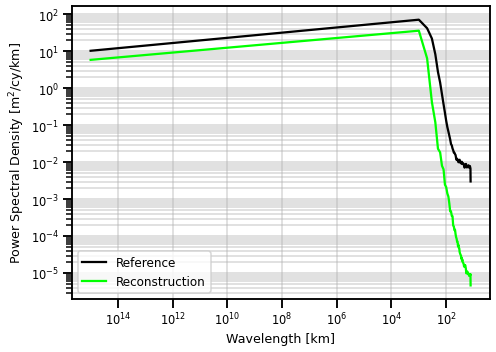

In [235]:
fig, ax = plot_psd_spectrum(
    psd_metrics.psd_study, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber
)


wandb.log(
    {
        "model_psd_spectrum": wandb.Image(fig),
    }
)

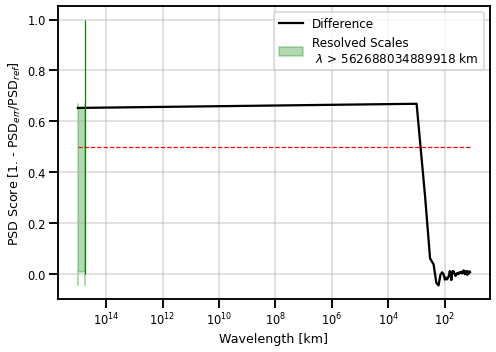

In [236]:
fig, ax = plot_psd_score(
    psd_metrics.psd_diff, 
    psd_metrics.psd_ref, 
    psd_metrics.wavenumber, 
    psd_metrics.resolved_scale)

wandb.log(
    {
        "model_psd_score": wandb.Image(fig),
    }
)

### Movies

In [118]:
wandb.finish()

In [42]:
# save_path = wandb.run.dir #Path(root).joinpath("experiments/dc_2021b")

In [43]:
# import hvplot.xarray


# ds_oi.ssh.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="viridis")

In [44]:
# create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)

<!-- ![](wandb/run-20220601_174733-kx2nr6qb/files/movie_pred.gif) -->

In [45]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh.isel(time=slice(50,60)), f"pred", "time", cmap="viridis", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh, f"pred", "time", cmap="viridis", file_path=save_path)


In [46]:
# wandb.log(
#     {
#         "predictions_gif": wandb.Image(f"{save_path}/movie_pred.gif"),
#     }
# )

### Gradients

In [47]:
ds_oi["ssh_grad"] = calculate_gradient(ds_oi["ssh"], "longitude", "latitude")

In [48]:
# ds_oi.ssh_grad.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="Spectral_r")

In [49]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_grad.isel(time=slice(50,60)), f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_grad, f"pred_grad", "time", cmap="Spectral_r", file_path=save_path)

In [50]:
# wandb.log(
#     {
#         "predictions_grad_gif": wandb.Image(f"{save_path}/movie_pred_grad.gif"),
#     }
# )

### Laplacian

In [51]:
ds_oi["ssh_lap"] = calculate_laplacian(ds_oi["ssh"], "longitude", "latitude")

In [52]:
# ds_oi.ssh_lap.hvplot.image(
#     x="longitude",
#     y="latitude",
#     # groupby='time',
#     # rasterize=True, 
#     width=500, height=400, cmap="RdBu_r")

In [53]:
# if args.smoke_test:
#     create_movie(ds_oi.ssh_lap.isel(time=slice(50,60)), f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)
# else:
#     create_movie(ds_oi.ssh_lap, f"pred_lap", "time", cmap="RdBu_r", file_path=save_path)


In [54]:
# wandb.log(
#     {
#         "predictions_laplacian_gif": wandb.Image(f"{save_path}/movie_pred_lap.gif"),
#     }
# )